# Aggregated trajectory

In this tutorial, we will examine the aggregation of trajectories using two matching distances: the Fréchet distance and the DTW-L2 distance, and thus see its ability to reconstruct accurately the common path followed by all the individual sample trajectories by comparing the position errors and the shape deviation.

Our experiment will be conducted in four steps:
1. Step 1: creating a synthetically reference track considered as the ground truth track,
2. Step 2: creating a set of simulated tracks from the reference track, 
3. Step 3: computing the aggregation track from the set previously constructed (step 2),
4. Step 4: the error between the estimated and ground truth track is then evaluated.

This tutorial is based on the work presented in [1 SIGSPATIAL 2024]

<div class="alert alert-block alert-info">
<b>References:</b><ul>
<li>[1 SIGSPATIAL 2024] TODO </li>
<li>[Ripley (2009)] - Ripley, B.D., 2009. Stochastic simulation. vol. 316. Hoboken, NJ: John Wiley & Sons.</li>
<li>[Ménéroux (2022)] - Méneroux, Y., Maidaneh Abdi, I., Le Guilcher, A., & Olteanu-Raimond, A. M. (2022). Is the radial distance really a distance? An analysis of its properties and interest for the matching of polygon features. International Journal of Geographical Information Science, 37(2), 438–475. https://doi.org/10.1080/13658816.2022.2123487</li>
</ul>    
</div>


## As usual, let’s start by defining our environment

1/ The first task is **only useful for the online notebook** and import the local tracklib code source. This script is not necessary if tracklib is installed from PyPI.

In [1]:
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tracklib as tkl


2/ The following imports are **necessary** for the tutorial.

In [2]:
import csv
import math
import numpy as np

# For 
from random import randint

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

3/ Let's define a function to plot results: 
<br/>
<span style='padding-left:2em'>(i) *visualizeAggTraj:* display the track reference and aggregated tracks</span><br/>

In [13]:
color = cm.rainbow(np.linspace(0, 1, 50))

def visualizeAggTraj(i, N=3, track=None, tracks=None, title=None):
    '''
    '''
    ax = plt.subplot2grid((1,N), (0,i))
    
    if tracks != None and isinstance(tracks, tkl.TrackCollection):
        for (i, t) in enumerate(tracks):
            ax.plot(t.getX(), t.getY(), c=color[i])
    
    if tracks != None and isinstance(tracks, tkl.Track):
        central = tracks
        ax.plot(central.getX(), central.getY(), 'c-')
    
    ax.plot(track.getX(), track.getY(), 'k-')
    if title != None:
        ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Y')
    ax.grid()
 

## Step 1: Create reference tracks

For this experimentation, we will examine the trajectory aggregation process for different types of paths to be reconstructed. In the context of mountain hiking, we identified three characteristic path shapes: nearly straight segments, moderately sinuosity road segments, and a zigzagging path composed of a series of switchbacks. To maintain shape consistency throughout the entire road segment, the generated trajectories have a length of approximately 300 meters.

This three commonly mountain path shapes correspond to the reference tracks.

In [4]:
tkl.seed(123)

SHAPES = ['Almost straight', 'Moderate sinuosity', 'Switchbacks']

# ----------------------------------------------------------
# Generate the path 'Almost straight'
sentier1 = tkl.generate(0.5, dt=10)[::3]
sentier1.scale(5)

# ----------------------------------------------------------
sentier2 = tkl.generate(0.1, dt=10)[::3]

# ----------------------------------------------------------
base_lacets = tkl.generate(0.4, dt=10)
sentier3 = tkl.noise(base_lacets, 20, tkl.SincKernel(20),
                    direction=tkl.MODE_DIRECTION_ORTHO)[::3]
sentier3.scale(4)

# ----------------------------------------------------------
sentiers = [sentier1, sentier2, sentier3]


Generated track from 05/02/2042 00:44:56 to 05/02/2042 01:44:56 [360 pts, 64.1m]
Generated track from 10/10/1982 08:02:44 to 10/10/1982 09:02:44 [360 pts, 297.54m]
Generated track from 25/11/2004 23:29:18 to 26/11/2004 00:29:18 [360 pts, 79.85m]


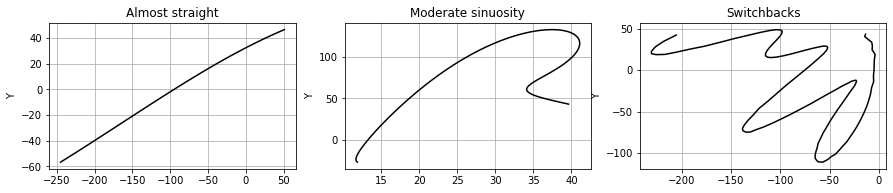

In [5]:
# ----------------------------------------------------------
# Plot
print ('')
plt.figure(figsize=(15, 3))
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.5)

visualizeAggTraj(0, track=sentier1, title='Almost straight')
visualizeAggTraj(1, track=sentier2, title='Moderate sinuosity')
visualizeAggTraj(2, track=sentier3, title='Switchbacks')
plt.show()

## Step 2: Create sets of simulated GNSS trajectories

Now that we have our three reference trajectories, we want to create three sets of N simulated GNSS trajectories from them.

To generate realistic noise, we used an approach described in [Ripley (2009)] and also employed in [Ménéroux (2022)]: 

With a random generator, we sampled $N$ i.i.d. unit-variance and zero-mean gaussian values, compiled in a vector $\mathbf{x}$. It can easily be shown that, for any positive-definite matrix $\mathbf{\Sigma} \in \mathbb{R}^{n \times n}$, the random vector $\mathbf{y} = \mathbf{Ax}$ where $\mathbf{A}$ is a Cholesky factor of $\mathbf{\Sigma}$, is a realization of a correlated random vector $\mathbf{Y}$ having covariance matrix $\Sigma$. The covariance matrix $\mathbf{\Sigma}$ is formed with a (stationary) covariance kernel with three parameters:

* The **type of kernel**: exponential, gaussian, and triangular models are used.
* The **amplitude** of noise: is between 0 and 5 meters, as it is quite uncommon to find building databases with more than 5 m error amplitude. If necessary, the output tables could be extended to handle large errors.
* The correlation **scope** of the noise which roughly speaking describes how far apart two errors would remain correlated (in both amplitude and direction): between 1 m (white noise) and 1000 m (global translation).

In tracklib, you have to create a Kernel and use the noise method on a track:

```python
amp = 3
scope = 20
kernel = GaussianKernel(scope)              # GaussianKernel
# kernel = ExponentialKernel(scope)         # ExponentialKernel
# kernel = TriangularKernel(scope)          # TriangularKernel
tracks.noise(amp, kernel)
```

Trajectories have been generated with: 

- a noise generated with a 50 m range Gaussian Process and with a 50 cm-amplitude for referencement error
- completed by a noise generated with a 5 m-amplitude exponential covariance process (GPS error) with a 20 m correlation scope
- and completed by 1 m white noise process (vibrations, electronic noise, etc.)

Which gives:

```python
tracks.noise(0.5, tkl.GaussianKernel(100))
tracks.noise(3, tkl.ExponentialKernel(50))
tracks.noise(0.5, tkl.DiracKernel())
```

In [6]:
N = 50

# ----------------------------------------------------------
# Generate 'Almost straight'
tracks1 = tkl.core.TrackCollection([sentier1]*N)
tracks1.noise(0.5, tkl.GaussianKernel(100))
tracks1.noise(3, tkl.ExponentialKernel(50))
tracks1.noise(0.5, tkl.DiracKernel())

# ----------------------------------------------------------
# Generate 'Moderate sinuosity'
tracks2 = tkl.core.TrackCollection([sentier2]*N)
tracks2.noise(0.5, tkl.GaussianKernel(100))
tracks2.noise(3, tkl.ExponentialKernel(50))
tracks2.noise(0.5, tkl.DiracKernel())

# ----------------------------------------------------------
# Generate 'Switchbacks'
tracks3 = tkl.core.TrackCollection([sentier3]*N)
tracks3.noise(0.5, tkl.GaussianKernel(100))
tracks3.noise(3, tkl.ExponentialKernel(50))
tracks3.noise(0.5, tkl.DiracKernel())


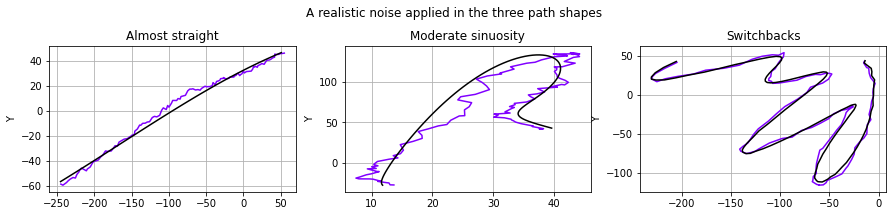

In [7]:
# ----------------------------------------------------------
# Visualize one realistic noise track
print ('')

plt.figure(figsize=(15, 3))
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.5)
visualizeAggTraj(0, N=3, track=sentier1, tracks=tracks1[0:1], title='Almost straight')
visualizeAggTraj(1, N=3, track=sentier2, tracks=tracks2[0:1], title='Moderate sinuosity')
visualizeAggTraj(2, N=3, track=sentier3, tracks=tracks3[0:1], title='Switchbacks')
plt.suptitle('A realistic noise applied in the three path shapes')
plt.show()

## Step 3: Compute aggregated trajectory

We have two evaluations to do: compute the aggregated trajectory with Frechet distance and with $L_2$ distance. 

Each one is conducted as follows: we generate $N'$ random noisy traces, with $N' \in [1, E]$ and $E \le N$. For each generation, we are going to compare the agregated trajectory against the reference track (*i.e.* the ground truth). 

The computations took a lot of time !

In [8]:
E = 20
FRECHET = {'Almost straight': tkl.TrackCollection(), 'Moderate sinuosity': tkl.TrackCollection(), 'Switchbacks': tkl.TrackCollection()}
DTW = {'Almost straight': tkl.TrackCollection(), 'Moderate sinuosity': tkl.TrackCollection(), 'Switchbacks': tkl.TrackCollection()}

represent_method = tkl.MODE_REP_BARYCENTRE
agg_method = tkl.MODE_AGG_MEDIAN
constraint = False
master = tkl.MODE_MASTER_MEDIAN_LEN
itermax = 15

for s in range(1, E+1):
    print ('Sample size: ', s)
    # create set
    TAB = set()
    while len(TAB) <= s:
        n = randint(0, N-1)
        TAB.add(n)

    sets1 = tkl.TrackCollection()
    sets2 = tkl.TrackCollection()
    sets3 = tkl.TrackCollection()
    for idx in TAB:
        sets1.addTrack(tracks1[idx])
        sets2.addTrack(tracks2[idx])
        sets3.addTrack(tracks3[idx])

    # ---------------------------------------------------------------------------
    # Fréchet
    p = float('inf')
    mode = tkl.MODE_MATCHING_FRECHET
    print ('    FRECHET')

    central1 = tkl.fusion(sets1, master=master, dim=2, mode=mode, p=p, represent_method=represent_method,  agg_method=agg_method,
                         constraint=constraint, verbose=False, iter_max = itermax)
    FRECHET['Almost straight'].addTrack(central1)

    central2 = tkl.fusion(sets2, master=master, dim=2, mode=mode, p=p, represent_method=represent_method,  agg_method=agg_method,
                         constraint=constraint, verbose=False, iter_max = itermax)
    FRECHET['Moderate sinuosity'].addTrack(central2)

    central3 = tkl.fusion(sets3, master=master, dim=2, mode=mode, p=p, represent_method=represent_method,  agg_method=agg_method,
                         constraint=constraint, verbose=False, iter_max = itermax)
    FRECHET['Switchbacks'].addTrack(central3)

    # ---------------------------------------------------------------------------
    # DTW
    p = 2
    mode = tkl.MODE_MATCHING_DTW
    print ('    DTW')
    
    central1 = tkl.fusion(sets1, master=master, dim=2, mode=mode, p=p, represent_method=represent_method,  agg_method=agg_method,
                         constraint=constraint, verbose=False, iter_max = itermax)
    DTW['Almost straight'].addTrack(central1)

    central2 = tkl.fusion(sets2, master=master, dim=2, mode=mode, p=p, represent_method=represent_method,  agg_method=agg_method,
                         constraint=constraint, verbose=False, iter_max = itermax)
    DTW['Moderate sinuosity'].addTrack(central2)

    central3 = tkl.fusion(sets3, master=master, dim=2, mode=mode, p=p, represent_method=represent_method,  agg_method=agg_method,
                         constraint=constraint, verbose=False, iter_max = itermax)
    DTW['Switchbacks'].addTrack(central3)



Sample size:  1
    FRECHET
    DTW
Sample size:  2
    FRECHET
    DTW
Sample size:  3
    FRECHET
    DTW
Sample size:  4
    FRECHET
    DTW
Sample size:  5
    FRECHET
    DTW
Sample size:  6
    FRECHET
    DTW
Sample size:  7
    FRECHET
    DTW
Sample size:  8
    FRECHET
    DTW
Sample size:  9
    FRECHET
    DTW
Sample size:  10
    FRECHET
    DTW
Sample size:  11
    FRECHET
    DTW
Sample size:  12
    FRECHET
    DTW
Sample size:  13
    FRECHET
    DTW
Sample size:  14
    FRECHET
    DTW
Sample size:  15
    FRECHET
    DTW
Sample size:  16
    FRECHET
    DTW
Sample size:  17
    FRECHET
    DTW
Sample size:  18
    FRECHET
    DTW
Sample size:  19
    FRECHET
    DTW
Sample size:  20
    FRECHET
    DTW


The figure presents all aggregated trajectory for $N'$ = 1, 5, 15, 20

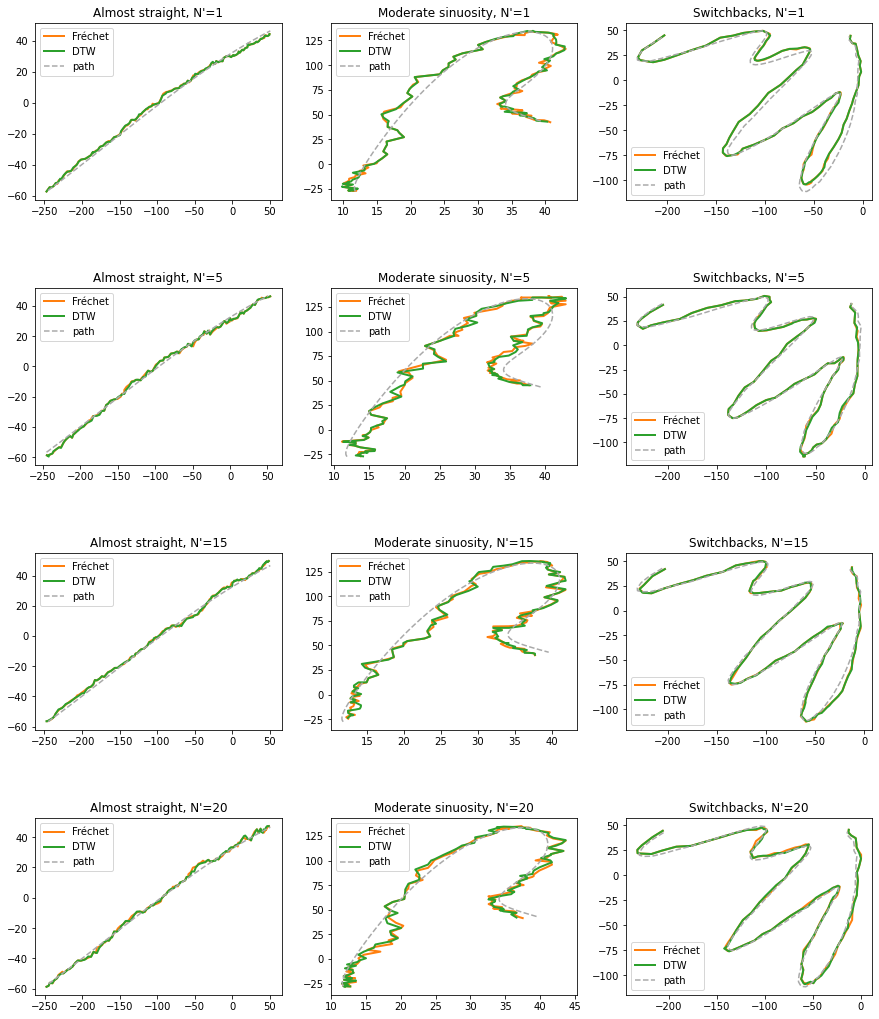

In [9]:
T = [1, 5, 15, 20]

plt.figure(figsize=(15, 20))
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.5)

for i in range(len(T)):
    for s, title in enumerate(SHAPES):
        ax = plt.subplot2grid((len(T), len(SHAPES)), (i, s))
    
        c = FRECHET[title][i]
        ax.plot(c.getX(), c.getY(), label="Fréchet", color="tab:orange", linewidth=2.0)
        c = DTW[title][i]
        ax.plot(c.getX(), c.getY(), label="DTW", color="tab:green", linewidth=2.0)
        ax.plot(sentiers[s].getX(), sentiers[s].getY(), label='path', color='darkgrey', linestyle='--')
        ax.legend()
        title = title + ", N'=" + str(T[i])
        ax.set_title(title)

## Step 4: Evaluate error between the aggregated and ground truth track

### Position error measurement

We compute the distance $pointwise L_2$ (*Root Mean Square Error*) by finely resampling both the aggregated and ground truth trajectories from 120 to 1,000 points, ensuring one point every 30 cm over 300 meters.

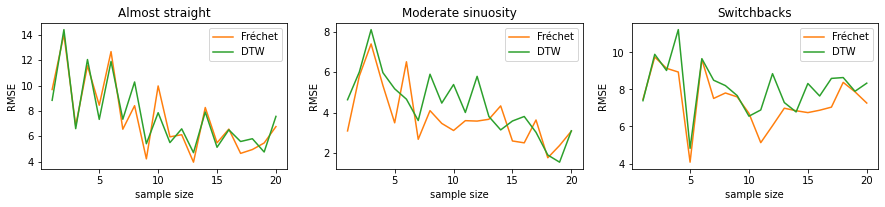

In [10]:
def rmse(central, sentier):
    central.resample(npts=1000, mode=1)
    sentier.resample(npts=1000, mode=1)
    m = min(sentier.size(), central.size())
    
    # compute the distance NearestNeighbour
    return tkl.compare(central[0:m], sentier[0:m], tkl.MODE_COMPARISON_POINTWISE, p=2)

TSS = []
T1F=[]; T2F=[]; T3F=[]
T1D=[]; T2D=[]; T3D=[]
for s in range(0, E):
    TSS.append(s+1)
    T1F.append(rmse(FRECHET['Almost straight'][s], sentier1))
    T2F.append(rmse(FRECHET['Moderate sinuosity'][s], sentier2))
    T3F.append(rmse(FRECHET['Switchbacks'][s], sentier3))
    T1D.append(rmse(DTW['Almost straight'][s], sentier1))
    T2D.append(rmse(DTW['Moderate sinuosity'][s], sentier2))
    T3D.append(rmse(DTW['Switchbacks'][s], sentier3))


plt.figure(figsize=(15, 3))
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.5)
    
ax1 = plt.subplot2grid((1,3), (0,0))
ax1.plot(TSS, T1D, label="Fréchet", color="tab:orange")
ax1.plot(TSS, T1F, label="DTW", color="tab:green")
ax1.set_xlabel('sample size')
ax1.set_ylabel("RMSE")
ax1.set_title('Almost straight')
ax1.legend()

ax2 = plt.subplot2grid((1,3), (0,1))
ax2.plot(TSS, T2D, label="Fréchet", color="tab:orange")
ax2.plot(TSS, T2F, label="DTW", color="tab:green")
ax2.set_xlabel('sample size')
ax2.set_ylabel("RMSE")
ax2.set_title('Moderate sinuosity')
ax2.legend()

ax3 = plt.subplot2grid((1,3), (0,2))
ax3.plot(TSS, T3D, label="Fréchet", color="tab:orange")
ax3.plot(TSS, T3F, label="DTW", color="tab:green")
ax3.set_xlabel('sample size')
ax3.set_ylabel("RMSE")
ax3.set_title('Switchbacks')
ax3.legend()

plt.show()

### Shape deviation measurement

Let's start by aligning the aggregated track with the reference track to abstract away from position issues. Then, we finely resample both the aggregated and ground truth trajectories from 120 to 1,000 points, ensuring one point every 30 cm over 300 meters. Finally, we compute the distance *NearestNeighbour* for all positions to estimate shape deviation.

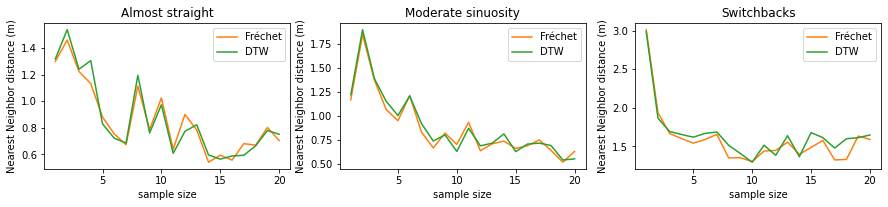

In [11]:
def shapeDeviationMeasure(central, sentier):
    # Align the aggregated track with the reference track
    tkl.mapping.mapOn(central, sentier, verbose=False)

    # resample to 1000 points
    central.resample(npts=1000, mode=1)
    sentier.resample(npts=1000, mode=1)

    # compute the distance NearestNeighbour
    return tkl.compare(central, sentier, tkl.MODE_COMPARISON_NN, p=2, verbose=False)
    

TSS = []
T1F=[]; T2F=[]; T3F=[]
T1D=[]; T2D=[]; T3D=[]
for s in range(0, E):
    TSS.append(s+1)
    T1F.append(shapeDeviationMeasure(FRECHET['Almost straight'][s], sentier1))
    T2F.append(shapeDeviationMeasure(FRECHET['Moderate sinuosity'][s], sentier2))
    T3F.append(shapeDeviationMeasure(FRECHET['Switchbacks'][s], sentier3))
    T1D.append(shapeDeviationMeasure(DTW['Almost straight'][s], sentier1))
    T2D.append(shapeDeviationMeasure(DTW['Moderate sinuosity'][s], sentier2))
    T3D.append(shapeDeviationMeasure(DTW['Switchbacks'][s], sentier3))
    

plt.figure(figsize=(15, 3))
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.5)
    
ax1 = plt.subplot2grid((1,3), (0,0))
ax1.plot(TSS, T1D, label="Fréchet", color="tab:orange")
ax1.plot(TSS, T1F, label="DTW", color="tab:green")
ax1.set_xlabel('sample size')
ax1.set_ylabel("Nearest Neighbor distance (m)")
ax1.set_title('Almost straight')
ax1.legend()

ax2 = plt.subplot2grid((1,3), (0,1))
ax2.plot(TSS, T2D, label="Fréchet", color="tab:orange")
ax2.plot(TSS, T2F, label="DTW", color="tab:green")
ax2.set_xlabel('sample size')
ax2.set_ylabel("Nearest Neighbor distance (m)")
ax2.set_title('Moderate sinuosity')
ax2.legend()

ax3 = plt.subplot2grid((1,3), (0,2))
ax3.plot(TSS, T3D, label="Fréchet", color="tab:orange")
ax3.plot(TSS, T3F, label="DTW", color="tab:green")
ax3.set_xlabel('sample size')
ax3.set_ylabel("Nearest Neighbor distance (m)")
ax3.set_title('Switchbacks')
ax3.legend()

plt.show()

## To add to the gallery

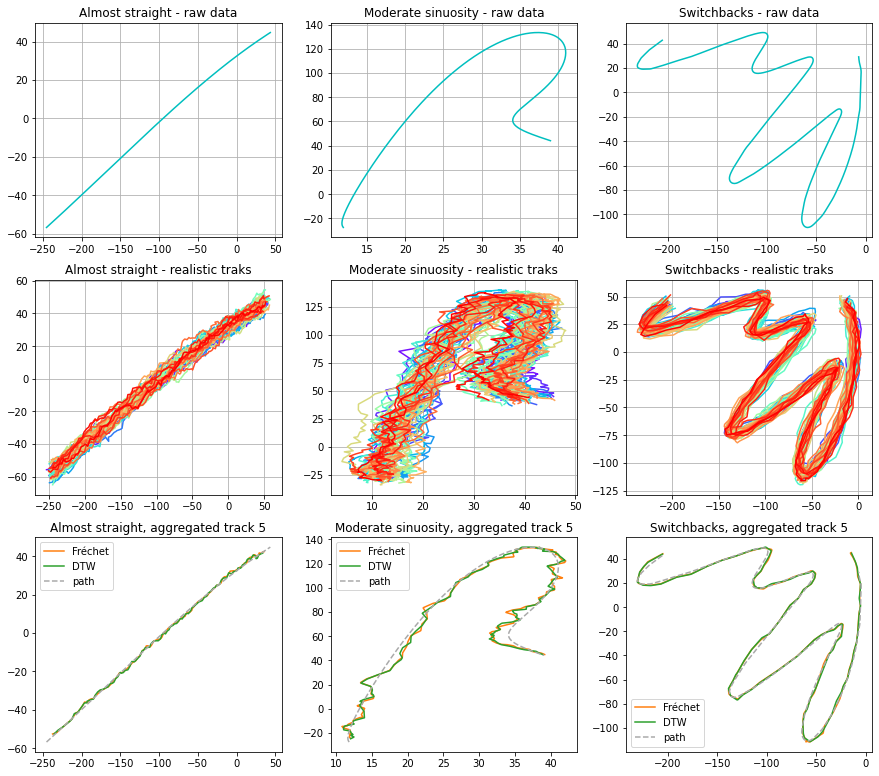

In [14]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.2)

ax = plt.subplot2grid((3,3), (0,0))
ax.plot(sentier1.getX(), sentier1.getY(), 'c-')
ax.set_title('Almost straight - raw data')
ax.set_xlabel(''); 
ax.set_ylabel('')
ax.grid()

ax = plt.subplot2grid((3,3), (0,1))
ax.plot(sentier2.getX(), sentier2.getY(), 'c-')
ax.set_title('Moderate sinuosity - raw data')
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()

ax = plt.subplot2grid((3,3), (0,2))
ax.plot(sentier3.getX(), sentier3.getY(), 'c-')
ax.set_title('Switchbacks - raw data')
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()

ax = plt.subplot2grid((3,3), (1,0))
ax.plot(sentier1.getX(), sentier1.getY(), 'c-')
for (i, t) in enumerate(tracks1):
    ax.plot(t.getX(), t.getY(), c=color[i])
ax.set_title('Almost straight - realistic traks')
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()

ax = plt.subplot2grid((3,3), (1,1))
ax.plot(sentier2.getX(), sentier2.getY(), 'c-')
for (i, t) in enumerate(tracks2):
    ax.plot(t.getX(), t.getY(), c=color[i])
ax.set_title('Moderate sinuosity - realistic traks')
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()

ax = plt.subplot2grid((3,3), (1,2))
ax.plot(sentier3.getX(), sentier3.getY(), 'c-')
for (i, t) in enumerate(tracks3):
    ax.plot(t.getX(), t.getY(), c=color[i])
ax.set_title('Switchbacks - realistic traks')
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid()

ax = plt.subplot2grid((3, 3), (2,0))
c = FRECHET['Almost straight'][4]
ax.plot(c.getX(), c.getY(), label="Fréchet", color="tab:orange")
c = DTW['Almost straight'][4]
ax.plot(c.getX(), c.getY(), label="DTW", color="tab:green")
ax.plot(sentier1.getX(), sentier1.getY(), color='darkgrey', linestyle='--', label='path')
ax.legend()
title = "Almost straight, aggregated track 5"
ax.set_title(title)

ax = plt.subplot2grid((3, 3), (2,1))
c = FRECHET['Moderate sinuosity'][4]
ax.plot(c.getX(), c.getY(), label="Fréchet", color="tab:orange")
c = DTW['Moderate sinuosity'][4]
ax.plot(c.getX(), c.getY(), label="DTW", color="tab:green")
ax.plot(sentier2.getX(), sentier2.getY(), color='darkgrey', linestyle='--', label='path')
ax.legend()
title = "Moderate sinuosity, aggregated track 5"
ax.set_title(title)

ax = plt.subplot2grid((3, 3), (2,2))
c = FRECHET['Switchbacks'][4]
ax.plot(c.getX(), c.getY(), label="Fréchet", color="tab:orange")
c = DTW['Switchbacks'][4]
ax.plot(c.getX(), c.getY(), label="DTW", color="tab:green")
ax.plot(sentier3.getX(), sentier3.getY(), color='darkgrey', linestyle='--', label='path')
ax.legend()
title = "Switchbacks, aggregated track 5"
ax.set_title(title)

plt.show()